In [1]:
import re
import os
import numpy as np
import pandas as pd
import nltk
import sklearn
from sklearn.model_selection import train_test_split
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchtext
from collections import Counter
from scipy import sparse
import random
import matplotlib.pyplot as plt; plt.rcdefaults()
import string
import ktrain
from ktrain import text
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm
import math
import emoji
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from twitterFunctions.processing import processMe, process_token_fin, fix_emotes
from twitterFunctions.performanceMetrics import get_performance 
from twitterFunctions.cross_validation import run_SVM_CV

I1012 23:58:39.657757  6588 modeling.py:230] Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .
I1012 23:58:39.684717  6588 modeling_bert.py:226] Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .
I1012 23:58:39.693720  6588 modeling_xlnet.py:339] Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .


In [2]:
# load training data
file = "./data/training_posts20201201_main_categories.tsv"
# read training data
df = pd.read_csv(file, sep="\t")

In [3]:
# filter relevant columns
df = df[["notserious_unclear", "focus", "type", "main_category", "contents"]]
# rename class and text columns
colNames = ["notserious_unclear", "focus", "type", "class", "text"]
df.columns=colNames

<module 'matplotlib.pyplot' from 'C:\\Users\\Hubert\\AppData\\Roaming\\Python\\Python36\\site-packages\\matplotlib\\pyplot.py'>

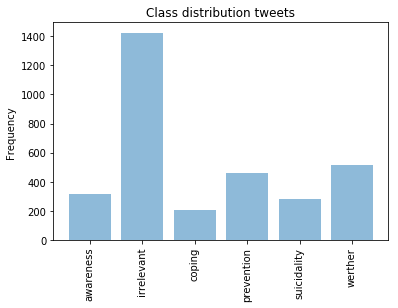

In [4]:
# here we print the class frequency distributions
freq_combined = Counter(df["class"].values)
objects = []
values = []
for i in freq_combined.keys():
    objects.append(i)
for i in freq_combined.values():
    values.append(i)
    
y_pos = np.arange(len(objects))

plt.bar(y_pos, values, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Frequency ')
plt.title('Class distribution tweets')
plt.xticks(rotation=90)
plt

In [5]:
# we run the preprocessing from the /twitterFunctions/processing.py
# here we use 3 functions (each loops over the entire dataset, they have to run sequentailly)
# if it takes too long one can make one function with all preprocessing - this recudes the runtime significantly
temp = df.text.apply(processMe)
# emojy mapping
emojis = temp.apply(emoji.emojize)
emojis = emojis.apply(fix_emotes)
cleaned_text = emojis
X_train_str = process_token_fin(cleaned_text)

In [30]:
# train val and test split
# stratify=df["class"] ensures that the subsets contain a similar distributions as original data
X_train, X_test, y_train, y_test = train_test_split(X_train_str
                    , df["class"],test_size=0.2, random_state=1, stratify=df["class"])

X_train, X_val, y_train, y_val = train_test_split(X_train
                    , y_train,test_size=0.2, random_state=1, stratify=y_train)

class_names = set(y_train.values)

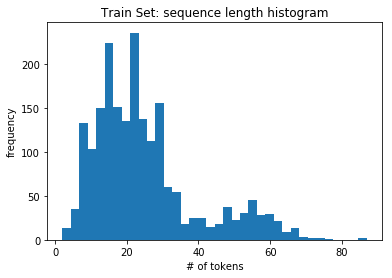

In [7]:
# visual analysis of number of tokens
ad = []
for i in X_train:
    ad.append( len(i.split(" ")) )
    
_ = plt.hist(ad, bins='auto')
plt.xlabel("# of tokens")
plt.ylabel("frequency")
plt.title("Train Set: sequence length histogram")
plt.show()

# Majority Classifier

In [8]:
majority_class = Counter(y_train).most_common()[0][0]
y_val_predicted = np.repeat(majority_class, len(y_val))
y_test_predicted = np.repeat(majority_class, len(y_test))

In [9]:
validation_results = get_performance(y_val, y_val_predicted, list(Counter(y_train).keys()))
test_results = get_performance(y_test, y_test_predicted, list(Counter(y_train).keys()))

Prec:  0.07439896036387264 ; Rec:  0.16666666666666666 F1:  0.10287511230907458 ; Acc:  0.44639376218323584
[[  0   0  50   0   0   0]
 [  0   0  33   0   0   0]
 [  0   0 229   0   0   0]
 [  0   0  73   0   0   0]
 [  0   0  46   0   0   0]
 [  0   0  82   0   0   0]]
Prec:  0.07410296411856475 ; Rec:  0.16666666666666666 F1:  0.10259179265658748 ; Acc:  0.44461778471138846
[[  0   0  63   0   0   0]
 [  0   0  42   0   0   0]
 [  0   0 285   0   0   0]
 [  0   0  91   0   0   0]
 [  0   0  57   0   0   0]
 [  0   0 103   0   0   0]]


C:\Users\Hubert\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hubert\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# TFIDF

In [10]:
print("Validation Performance: \n")
model = run_SVM_CV(X_train, X_val, y_train, y_val)
pred = model.predict(X_test)
print("Test Performance: \n")
mat = get_performance(y_test.values, pred, list(class_names))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Validation Performance: 

Fitting 5 folds for each of 136 candidates, totalling 680 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 680 out of 680 | elapsed:  3.8min finished


{'clf__C': 0.97, 'clf__class_weight': 'balanced', 'clf__decision_function_shape': 'ovo', 'vect__ngram_range': (1, 1)}
F1: 0.609 | Pr: 0.659 | Re: 0.579 | Accuracy: 0.680 

[[ 17   1  28   1   0   3]
 [  1  16  10   1   5   0]
 [  5   7 186   1  16  14]
 [  4   0  14  54   0   1]
 [  0   6  21   1  18   0]
 [  1   0  23   0   0  58]]
Test Performance: 

Prec:  0.6259824155445884 ; Rec:  0.5600564039756681 F1:  0.5859878765090417 ; Acc:  0.6489859594383776
[[ 26   1  32   1   1   2]
 [  2  17  13   1   9   0]
 [ 11   8 216   3  14  33]
 [  1   1  17  69   3   0]
 [  0   7  28   0  22   0]
 [  0   0  31   6   0  66]]


TypeError: iteration over a 0-d array

# Training BERT model

In [ ]:
original_learner = train_learner(
        df_train.text.values, df_train["class"].values, #X_train, y_train.values,
        X_val, y_val.values,
        lr= 1.5e-5, epoch=5, seed=1, text_length=80 , # parameters for the training
        checkpoint_folder="D:/models/test/"   # add the path where the checkpoints should be saved
    )

## After the training has finished, you will see the training statistics. I usually choose the epoch with the highest validation accuracy (if two performances were similar I chose the one with the lower validation loss).

If you used a checkpoint folder, you can load the model with the best performance rather than the last epoch. E.g. if you trained for 5 epochs, the default behaviour is that the model will use the last run, i.e. epoch 5. But if the performance of epoch 5 is worse than epoch 3, you can manually load the weights of epoch 3. See below:

In [ ]:
original_learner[4].load_weights("D:/models/test/weights-01.hdf5") # your path + weights-01.hdf5
# where weights-*BEST_EPOCH*.hdf5

learner_reloaded = ktrain.get_learner(original_learner[4], train_data=original_learner[2], val_data=original_learner[3], batch_size=2)

model_ = learner_reloaded
t_ = original_learner[1]
trn_ = original_learner[2]
# setting seeds (redundantly) before predicting validation set
set_seeds(seed)
# usually you only have to do this if you are interested in inter-class statistics of the validation set:D
## PREDICT ON VALIDATION SET
pred = predict_test(X_val, model_, 
                    t=t_,
                    trn=trn_)
predictor = pred[1]
val = t_.preprocess_test(X_val, y_val.values)
model_.validate(val_data= val )
mat = get_performance(y_val.values, pred[0], classNames2)

# predict TEST set, this one you must always do!
set_seeds(seed)
pred = predict_test(X_test, model_, 
                    t=t_,
                    trn=trn_)
predictor = pred[1]
test = t_.preprocess_test(X_test, y_test.values)
model_.validate(val_data= test , class_names = list(classNames2))
mat = get_performance(y_test.values, pred[0], classNames2)

## Saving a ktrain model

If the test performance was good, and you want to save the actual model (not only the weights of the training) call **predictor.save( "yourPath")**.

In [ ]:
#predictor.save('D:/models/Twitter_6_final')

In [ ]:
# this prints the confusion matrix for the test set and its predictions

mat = get_performance(y_test.values, pred, classNames2)

labels = y_test.values
capitalized = [i.capitalize() for i in classNames2]
index = columns = capitalized
cm_df = pd.DataFrame(mat/np.sum(mat),columns,index)                      
plt.figure(figsize=(10,8.2))  
sns.heatmap(cm_df, annot=True, fmt=".0%"
           )
plt.yticks(rotation=0, fontsize=12) 
plt.xlabel("Predicted class", fontsize=20)
plt.ylabel("Original class", fontsize=20)
plt.title("Confusion matrix test set, n=641", fontsize=25)

## Playing around with ELI5 text explainer to make the black box models a little more expalinable 

In [ ]:
df_test = pd.DataFrame({
    "text": X_test, 
    "true_label": y_test,
    "predicted_label": pred
})

In [ ]:
import eli5
from eli5.lime import TextExplainer
# select a specific test sample you want to investiage more clsoely
doc = X_test[0]

In [ ]:
# here we train a text explainer that runs n_samples to simualte the model behaviour
te = TextExplainer(random_state=42, n_samples=2500)
_ = te.fit(doc, reloaded_predictor.predict_proba)

In [ ]:
a = te.explain_prediction(target_names = reloaded_predictor.c, targets= pred[0])

In [ ]:
a